# Spot Rate, Par Yield, Zero-Coupn and Forward Curves from Coupon Bond Data with Matrix Operations

This notebook shows how to:
- Build a small set of example coupon bonds from a Svensson curve model
- Bootstrap discount factors and zero‑coupon (spot) rates using a matrix formulation
- Compute par yields implied by the same discount factors
- Compute one‑year forward rates between adjacent maturities
- Plot zero‑coupon, par, and forward curves on the same chart

We start by loading the libraries used for the calculations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 1. Generating example coupon bond data

We construct a small set of annual coupon bonds with different maturities, coupon rates, and prices from an assumed Svensson curve model.
This is the only input we need. How we generate the input data does not affect any of the calculations that we will discuss.


In [2]:
# We generate the input data from a smooth Svensson zero curve with added white noise.

def svensson_yield(t, beta0, beta1, beta2, beta3, tau1, tau2):
    """
    Nelson-Siegel-Svensson (Svensson) spot (zero) yield for maturity t (in years),
    with parameters beta0..beta3 and tau1, tau2.
    All rates returned in decimals (e.g. 0.03 = 3%).
    """
    t = np.asarray(t, dtype=float)
    x1 = t / tau1
    x2 = t / tau2

    term1 = (1 - np.exp(-x1)) / x1
    term2 = term1 - np.exp(-x1)
    term3 = (1 - np.exp(-x2)) / x2 - np.exp(-x2)

    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# The parameters which define the shape of the yield curve...
beta0 = 0.027626
beta1 = 0.010297
beta2 = -0.000027
beta3 = 0.070283
tau1  = 0.713749
tau2  = 16.228750

maturities = np.arange(1, 11, dtype=float)  # 1Y..10Y

# Smooth Svensson zero-coupon yields
y_svensson = svensson_yield(maturities, beta0, beta1, beta2, beta3, tau1, tau2)

# Add white noise
rng = np.random.default_rng(seed=42)
noise = rng.normal(loc=0.0, scale=0.0001, size=len(maturities))
y_noisy = y_svensson + noise

# Put into a DataFrame for later use
svensson_curve = pd.DataFrame(
    {
        "Tenor": maturities,
        "ZeroRateClean": y_svensson,
        "ZeroRateNoisy": y_noisy,
    }
)

# Convert noisy zeros to discount factors
DF_svensson = 1.0 / (1.0 + y_noisy) ** maturities

def price_coupon_bond(T, c, face, dfs):
    cash_flows = np.full(int(T), face * c, dtype=float)
    cash_flows[-1] += face
    return np.sum(cash_flows * dfs[:int(T)])

face = 100.0
coupon_spread = rng.normal(loc=0.0, scale=0.003, size=len(maturities))
coupon_rates = np.clip(y_noisy + coupon_spread, 0.005, 0.08)

prices = np.array([
    price_coupon_bond(T, c, face, DF_svensson)
    for T, c in zip(maturities, coupon_rates)
])

data = pd.DataFrame(
    {
        "Maturity": maturities.astype(int),
        "CouponRate": coupon_rates,
        "Price": prices,
    }
)
data



,Maturity,CouponRate,Price
0,1,0.037904,100.254832
1,2,0.037291,100.442222
2,3,0.036055,100.063237
3,4,0.040289,101.267836
4,5,0.039138,100.686801
5,6,0.036333,98.751853
6,7,0.041222,100.871228
7,8,0.038191,98.344411
8,9,0.044658,102.377729
9,10,0.042639,100.405646


## 2. Build the cash-flow matrix

We now construct the cash-flow matrix $A$ such that
$P = A \, d$, where:
- $P$ is the vector of bond prices,
- $A$ is the matrix of bond cash flows over time,
- $d$ is the vector of discount factors $d_t = DF_t$.

Assumptions:
- Annual coupon payments.
- Face value = 100.
- Time grid is annual: $t = 1, 2, \dots, \text{max maturity}$.


In [3]:
# Maximum maturity across bonds defines the curve horizon
max_T = int(data["Maturity"].max())

# Tenors 1..max_T (in years)
tenors = np.arange(1, max_T + 1, dtype=int)

# Cash‑flow matrix A (shape N x max_T)
# For each bond i with maturity T_i and coupon c_i:
#   CF_t = face * c_i   for t = 1..T_i-1
#   CF_T_i = face * (1 + c_i)

N = data.shape[0]
A = np.zeros((N, max_T), dtype=float)

for i, row in data.iterrows():
    T_i = int(row["Maturity"])
    c_i = float(row["CouponRate"])
    # Coupons for years 1..T_i-1
    if T_i > 1:
        A[i, :T_i - 1] = face * c_i
    # Final coupon + principal at maturity T_i
    A[i, T_i - 1] = face * (1.0 + c_i)

P = data["Price"].to_numpy(dtype=float)

# Print rounded versions for nicer display (2 decimals)
print("Cash-flow matrix A:")
print(np.round(A, 2))
print("\nPrice vector P:")
print(np.round(P, 2))


Cash-flow matrix A:
[[103.79   0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  3.73 103.73   0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  3.61   3.61 103.61   0.     0.     0.     0.     0.     0.     0.  ]
 [  4.03   4.03   4.03 104.03   0.     0.     0.     0.     0.     0.  ]
 [  3.91   3.91   3.91   3.91 103.91   0.     0.     0.     0.     0.  ]
 [  3.63   3.63   3.63   3.63   3.63 103.63   0.     0.     0.     0.  ]
 [  4.12   4.12   4.12   4.12   4.12   4.12 104.12   0.     0.     0.  ]
 [  3.82   3.82   3.82   3.82   3.82   3.82   3.82 103.82   0.     0.  ]
 [  4.47   4.47   4.47   4.47   4.47   4.47   4.47   4.47 104.47   0.  ]
 [  4.26   4.26   4.26   4.26   4.26   4.26   4.26   4.26   4.26 104.26]]

Price vector P:
[100.25 100.44 100.06 101.27 100.69  98.75 100.87  98.34 102.38 100.41]


## 3. Solve for discount factors and spot rates

We solve the (possibly over‑determined) linear system $P = A d$ for the discount factor vector $d$ in a least‑squares sense. Then we convert discount factors to annual spot rates with discrete compounding:
$$
DF_t = (1 + s_t)^{-t} \Rightarrow s_t = DF_t^{-1/t} - 1.
$$

The resulting spot rate curve is also the **zero‑coupon yield curve**.


In [4]:
# Solve P = A @ d in least squares sense for discount factors d
d, residuals, rank, svals = np.linalg.lstsq(A, P, rcond=None)
discount_factors = d

# Convert discount factors to annual spot rates (discrete compounding)
spot_rates = discount_factors ** (-1.0 / tenors) - 1.0

# Store zero‑coupon (spot) curve in a DataFrame
spot_curve = pd.DataFrame(
    {
        "Tenor": tenors,
        "DiscountFactor": discount_factors,
        "SpotRate": spot_rates,
    }
)

spot_curve

,Tenor,DiscountFactor,SpotRate
0,1,0.965935,0.035266
1,2,0.933588,0.034957
2,3,0.899707,0.035857
3,4,0.865047,0.036908
4,5,0.830933,0.037736
5,6,0.795300,0.038911
6,7,0.759327,0.040116
7,8,0.724716,0.041068
8,9,0.690410,0.042022
9,10,0.657711,0.042789


## 4. Compute par yields from discount factors

For each tenor \(T\), the **par yield** is the coupon rate on a bond that prices at par (100) given the discount factors. For annual coupons and face value 100, the par yield \(c_T\) satisfies:
$$
100 = c_T \cdot 100 \sum_{t=1}^T DF_t + 100 \cdot DF_T.
$$
Rearranging gives:
$$
c_T = \frac{1 - DF_T}{\sum_{t=1}^T DF_t}.
$$

We compute this for each tenor using the discount factors we bootstrapped.


In [5]:
# Compute par yields implied by the discount factors

DF = spot_curve["DiscountFactor"].to_numpy(dtype=float)
T = spot_curve["Tenor"].to_numpy(dtype=int)

par_yields = np.zeros_like(DF)

for i, t in enumerate(T):
    # Sum of discount factors up to t
    denom = DF[:t].sum()
    par_yields[i] = (1.0 - DF[i]) / denom

spot_curve["ParYield"] = par_yields

spot_curve

,Tenor,DiscountFactor,SpotRate,ParYield
0,1,0.965935,0.035266,0.035266
1,2,0.933588,0.034957,0.034963
2,3,0.899707,0.035857,0.035829
3,4,0.865047,0.036908,0.036829
4,5,0.830933,0.037736,0.037611
5,6,0.795300,0.038911,0.038692
6,7,0.759327,0.040116,0.039782
7,8,0.724716,0.041068,0.040635
8,9,0.690410,0.042022,0.041472
9,10,0.657711,0.042789,0.042140


## 5. Compute par yields from discount factors with matrix operations

For each tenor $T$, the **par yield** is the coupon rate on a bond that prices at par (100) given the discount factors. For annual coupons and face value 100, the par yield $c_T$ satisfies
$$
100 = c_T \cdot 100 \sum_{t=1}^T DF_t + 100 \cdot DF_T.
$$
Rearranging gives
$$
c_T = \frac{1 - DF_T}{\sum_{t=1}^T DF_t}.
$$

In vector form, if we collect the discount factors in
$$
d = (DF_1,\dots,DF_n)^\top,
$$
we can form the vector of cumulative sums
$$
s = L d,
$$
where $L$ is the $n \times n$ lower‑triangular matrix of ones. The par‑yield vector
$$
c = (c_1,\dots,c_n)^\top
$$
then follows elementwise as
$$
c = \frac{1 - d}{s},
$$
i.e. $c_T = (1 - DF_T)/s_T$.


In [6]:
# === Par yields from discount factors using a matrix operation ===
# We use the discount factors already stored in spot_curve["DiscountFactor"].
# Let d = (DF_1,...,DF_n). We build a lower-triangular matrix L of ones so that:
#   s = L @ d
# gives s_T = sum_{t=1..T} DF_t.
# Then c_T = (1 - DF_T) / s_T.

DF = spot_curve["DiscountFactor"].to_numpy(dtype=float)
n = DF.shape[0]

# Lower-triangular matrix of ones (n x n)
L = np.tril(np.ones((n, n), dtype=float))

# Prefix sums s_T = sum_{t=1..T} DF_t
prefix_sums = L @ DF

# Par yields c_T
par_yields_matrix = (1.0 - DF) / prefix_sums

# Store in the DataFrame (overwriting or creating ParYield)
spot_curve["ParYield_matrix"] = par_yields_matrix

spot_curve


,Tenor,DiscountFactor,SpotRate,ParYield,ParYield_matrix
0,1,0.965935,0.035266,0.035266,0.035266
1,2,0.933588,0.034957,0.034963,0.034963
2,3,0.899707,0.035857,0.035829,0.035829
3,4,0.865047,0.036908,0.036829,0.036829
4,5,0.830933,0.037736,0.037611,0.037611
5,6,0.795300,0.038911,0.038692,0.038692
6,7,0.759327,0.040116,0.039782,0.039782
7,8,0.724716,0.041068,0.040635,0.040635
8,9,0.690410,0.042022,0.041472,0.041472
9,10,0.657711,0.042789,0.042140,0.042140


## 6. Compute one-year forward rates

We now derive the one-year forward rates between adjacent maturities. With annual compounding and integer tenors, the forward rate from year $(t-1)$ to $t$ satisfies
$$
(1 + s_t)^t = (1 + s_{t-1})^{t-1} (1 + f_{t-1,t}),
$$
so that
$$
f_{t-1,t} = \frac{(1 + s_t)^t}{(1 + s_{t-1})^{t-1}} - 1.
$$

This gives a simple one-year forward curve consistent with the zero-coupon (spot) curve.


In [7]:
tenors_arr = spot_curve["Tenor"].to_numpy(dtype=int)
spots_arr = spot_curve["SpotRate"].to_numpy(dtype=float)

# One‑year forward rates between adjacent tenors
fwd_rates = np.full_like(spots_arr, np.nan, dtype=float)

for i in range(1, len(tenors_arr)):
    t = tenors_arr[i]
    prev_t = tenors_arr[i - 1]
    fwd_rates[i] = (1.0 + spots_arr[i])**t / (1.0 + spots_arr[i - 1])**prev_t - 1.0

spot_curve["FwdRate"] = fwd_rates

spot_curve

,Tenor,DiscountFactor,SpotRate,ParYield,ParYield_matrix,FwdRate
0,1,0.965935,0.035266,0.035266,0.035266,NaN
1,2,0.933588,0.034957,0.034963,0.034963,0.034648
2,3,0.899707,0.035857,0.035829,0.035829,0.037658
3,4,0.865047,0.036908,0.036829,0.036829,0.040066
4,5,0.830933,0.037736,0.037611,0.037611,0.041056
5,6,0.795300,0.038911,0.038692,0.038692,0.044804
6,7,0.759327,0.040116,0.039782,0.039782,0.047375
7,8,0.724716,0.041068,0.040635,0.040635,0.047758
8,9,0.690410,0.042022,0.041472,0.041472,0.049689
9,10,0.657711,0.042789,0.042140,0.042140,0.049717


## 7. Compute one-year forward rates with matrix operations
We now derive the one‑year forward rates between adjacent maturities using vector/matrix expressions.

Let the annual spot rates be collected in the vector  
$ s = (s_1, s_2, \dots, s_n)^\top $,  
with corresponding tenors  
$ t = (1, 2, \dots, n)^\top $.

Define the **growth vector**  
$ g = (g_1, \dots, g_n)^\top $, with
$$
g_t = (1 + s_t)^t.
$$

For annual compounding, the one‑year forward rate from year $(k)$ to $(k+1)$ satisfies
$$
(1 + s_{k+1})^{k+1}
= (1 + s_k)^k \, (1 + f_{k,k+1}),
$$
so
$$
f_{k,k+1}
= \frac{(1 + s_{k+1})^{k+1}}{(1 + s_k)^k} - 1
= \frac{g_{k+1}}{g_k} - 1.
$$

Collecting the forwards in  
$ f = (f_{0,1}, f_{1,2}, \dots, f_{n-1,n})^\top $,  
we adopt the convention
$$
f_{0,1} = s_1,
$$
and for $k = 1,\dots,n-1$,
$$
f_{k,k+1} = \frac{g_{k+1}}{g_k} - 1.
$$

In NumPy, this corresponds to:

- Build $g$ elementwise as $growth = (1 + spots)*tenors$.  
- Set $fwd[0] = spots[0]$.  
- Compute the remaining entries via the vectorized ratio  

Thus the entire forward‑rate vector $f$ is obtained by simple vector operations, without an explicit Python loop.



In [8]:
# === One-year forward rates from spot rates (vectorized) ===
# Tenors: 1,2,...,n (annual)
tenors = spot_curve["Tenor"].to_numpy(dtype=int)
spots = spot_curve["SpotRate"].to_numpy(dtype=float)
n = len(tenors)

# Compute (1 + s_t)^t for all t (this is like a diagonal matrix of growth factors times a 1-vector)
growth = (1.0 + spots) ** tenors    # shape (n,)

# f_{0,1} = s_1 by convention
fwd = np.empty_like(spots)
fwd[0] = spots[0]

# For t >= 2:  f_{t-1,t} = ( (1 + s_t)^t / (1 + s_{t-1})^{t-1} ) - 1
# Use vectorized ratio of adjacent growth terms
fwd[1:] = growth[1:] / growth[:-1] - 1.0

spot_curve["FwdRate_matrix"] = fwd

spot_curve


,Tenor,DiscountFactor,SpotRate,ParYield,ParYield_matrix,FwdRate,FwdRate_matrix
0,1,0.965935,0.035266,0.035266,0.035266,NaN,0.035266
1,2,0.933588,0.034957,0.034963,0.034963,0.034648,0.034648
2,3,0.899707,0.035857,0.035829,0.035829,0.037658,0.037658
3,4,0.865047,0.036908,0.036829,0.036829,0.040066,0.040066
4,5,0.830933,0.037736,0.037611,0.037611,0.041056,0.041056
5,6,0.795300,0.038911,0.038692,0.038692,0.044804,0.044804
6,7,0.759327,0.040116,0.039782,0.039782,0.047375,0.047375
7,8,0.724716,0.041068,0.040635,0.040635,0.047758,0.047758
8,9,0.690410,0.042022,0.041472,0.041472,0.049689,0.049689
9,10,0.657711,0.042789,0.042140,0.042140,0.049717,0.049717


## 8. Plot zero‑coupon, par, and forward curves

We plot on the same chart:
- The **zero‑coupon (spot) yield curve** (from discount factors)
- The **par yield curve** (coupon rate that prices a par bond at each tenor)
- The **one‑year forward curve** between adjacent maturities

All three are implied by the same discount factors, so they are internally consistent.

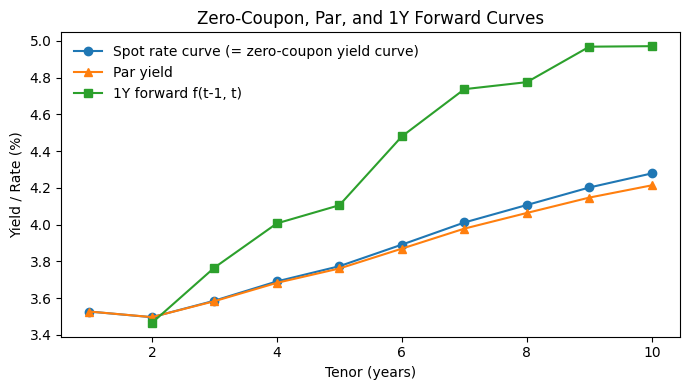

In [9]:
fig, ax = plt.subplots(figsize=(7, 4))

# Spot rate curve (equals the zero-coupon yield curve)
ax.plot(
    spot_curve["Tenor"],
    spot_curve["SpotRate"] * 100.0,
    marker="o",
    label="Spot rate curve (= zero-coupon yield curve)",
)

# Par yield curve
ax.plot(
    spot_curve["Tenor"],
    spot_curve["ParYield"] * 100.0,
    marker="^",
    label="Par yield",
)

# One‑year forward curve (skip NaN at t=1)
mask_fwd = ~spot_curve["FwdRate"].isna()
ax.plot(
    spot_curve.loc[mask_fwd, "Tenor"],
    spot_curve.loc[mask_fwd, "FwdRate"] * 100.0,
    marker="s",
    label="1Y forward f(t-1, t)",
)

ax.set_xlabel("Tenor (years)")
ax.set_ylabel("Yield / Rate (%)")
ax.set_title("Zero‑Coupon, Par, and 1Y Forward Curves")
ax.legend(frameon=False, loc="best")

plt.tight_layout()
plt.show()